In [190]:
import cv2
import time
import scipy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from tqdm.notebook import tqdm_notebook as tq

In [191]:
input_image = '/content/ghost3.png'
patch_dimension = [185, 245, 315, 375]
patch_width = int(np.abs(patch_dimension[0]-patch_dimension[1]))
patch_height = int(np.abs(patch_dimension[2]-patch_dimension[3]))

In [192]:
def getdim(image, scale_percent):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)
  return dim

In [193]:
def imageResize(image, scale_percent):
  dim = getdim(image, scale_percent)
  img_resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  return img_resized

In [194]:
def templateMatching(image,template, threshold):
  # threshold = 0.8
  img = np.copy(image)
  w,h = template.shape
  result = cv2.matchTemplate(image, template,cv2.TM_CCOEFF_NORMED)
  # (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)
  list_of_points = np.where( result >= threshold)
  for pt in zip(*list_of_points[::-1]):
      cv2.rectangle(img, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
  # print(result)
  return img, result

In [195]:
def find_d(data, neighborhood_size, threshold):
  # neighborhood_size = 6
  # threshold = 0.20
  # data = result

  data_max = filters.maximum_filter(data, neighborhood_size)
  maxima = (data == data_max)
  data_min = filters.minimum_filter(data, neighborhood_size)
  diff = ((data_max - data_min) > threshold)
  maxima[diff == 0] = 0

  labeled, num_objects = ndimage.label(maxima)
  slices = ndimage.find_objects(labeled)
  x, y = [], []
  for ey,ex in slices:
      x_center = (ex.start + ex.stop - 1)/2
      x.append(x_center)
      y_center = (ey.start + ey.stop - 1)/2    
      y.append(y_center)
  # print(x)
  # print(y)
  return x,y

def get_d(x,y):
  # x, y = find_d(data, neighborhood_size, threshold)
  dy = int(np.abs(x[0]-x[1]))
  dx = int(np.abs(y[0]-y[1]))
  # print(dx,dy)
  return dx, dy


In [196]:
def gradientWithCanny(image, threshold1, threshold2):
  img = np.copy(image)
  edges = cv2.Canny(img,threshold1,threshold2)
  return edges

# gradient with Morphological

In [197]:
def gradientSeperation(img, edges, neighborhood_size, threshold, dx, dy):
  reflection_image = np.zeros((img.shape))
  grad_new = np.zeros((img.shape))

  for i in tq(range(img.shape[0]-patch_height)):
    for j in tq(range(200,img.shape[1]-patch_width), leave=False):
      if(edges[i][j] == 255):
        temp =  img[i:i+patch_height, j:j+patch_width]
        data = templateMatching(np.copy(img),np.copy(temp), 0.8)
        # neighborhood_size = 6
        # threshold = 0.2
        data_max = filters.maximum_filter(data, neighborhood_size)
        maxima = (data == data_max)
        data_min = filters.minimum_filter(data, neighborhood_size)
        diff = ((data_max - data_min) > threshold)
        maxima[diff == 0] = 0

        labeled, num_objects = ndimage.label(maxima)
        slices = ndimage.find_objects(labeled)
        x, y = [], []
        for ey,ex in slices:
            x_center = (ex.start + ex.stop - 1)/2
            x.append(x_center)
            y_center = (ey.start + ey.stop - 1)/2    
            y.append(y_center)
            if((abs(i+dx -y_center)<=2 and abs(j+dy-x_center)<=2 )or(abs(i-dx -y_center)<=2 and abs(j-dy-x_center)<=2 )):
              grad_new[i][j] = 255
              reflection_image[i:i+patch_height,j:j+patch_width] = img[i:i+patch_height,j:j+patch_width]
  return reflection_image, grad_new

In [198]:
def showGradients(img, edges, neighborhood_size, threshold, dx, dy):
  reflection_image, grad_new = gradientSeperation(img, edges, neighborhood_size, threshold, dx, dy)
  global ref
  ref = reflection_image
  global sce
  sce = grad_new
  # plt.imshow(ref, cmap="gray")
  # plt.title("Reflection Image Gradient")
  # plt.show()
  # plt.imshow(sce, cmap="gray")
  # plt.title("Scene Image Gradient")
  # plt.show()
  g2 = np.zeros((img.shape))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if(grad_new[i][j] == 255):
        g2[i:i+patch_height,j:j+patch_width] = edges[i:i+patch_height,j:j+patch_width]
  scene2 = edges-g2
  return g2, scene2

In [202]:
def reflection_removal(gray_img, temp_patch):
    patch_image, template_matching_result = templateMatching(gray_img,temp_patch, 0.8)
    plt.imshow(patch_image, cmap='gray')
    plt.title("Slected Patch")
    cv2.imwrite("selected_patch.png", patch_image)
    plt.show()
    x, y = find_d(template_matching_result, 6, 0.20)
    plt.imshow(gray_img, cmap="gray")
    plt.title("Image with Maximas")
    plt.autoscale(False)
    plt.plot(x,y, 'ro')
    dx, dy = get_d(x,y)
    plt.show()
    gradient_edges = gradientWithCanny(gray_img, 20, 30)
    plt.imshow(gradient_edges, cmap="gray")
    plt.title("Gradient Image")
    plt.show()
    reflection_gradient, scene_gradient = showGradients(gray_img, gradient_edges, 6, 0.20, dx, dy)  
    plt.imshow(reflection_gradient, cmap="gray")
    plt.title("Reflection Image Gradient")
    cv2.imwrite("reflection_image.png", relfection_gradient)
    plt.show()
    plt.imshow(scene_gradient, cmap="gray")
    plt.title("Scene Image Gradient")
    cv2.imwrite("scene_image.png", scene_gradient)
    plt.show()
    return 0

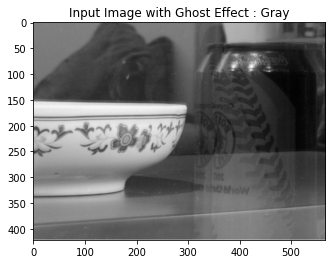

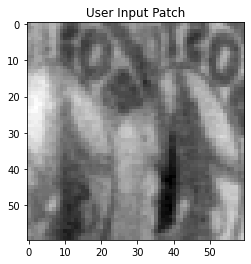

In [203]:
input_gray_image = cv2.cvtColor(cv2.imread(input_image), cv2.COLOR_BGR2GRAY)
input_gray_image = imageResize(input_gray_image, 50)
ref = np.zeros((input_gray_image.shape))
sce = np.zeros((input_gray_image.shape))
plt.imshow(input_gray_image, cmap="gray")
plt.title("Input Image with Ghost Effect : Gray")
plt.show()
template_patch = input_gray_image[patch_dimension[0]:patch_dimension[1], patch_dimension[2]: patch_dimension[3]]
plt.imshow(template_patch, cmap="gray")
plt.title("User Input Patch")
plt.show()

In [ ]:
reflection_removed_gray_image = reflection_removal(np.copy(input_gray_image), np.copy(template_patch))

In [ ]:
def image_reconstruction(image, reflection_edges, medianBlurringFilterSize, dilationFilterSize):
    blurred_image = cv2.medianBlur(image, medianBlurringFilterSize)
    dilated_reflection_edges = cv2.dilate(reflection_edges, np.ones((dilationFilterSize, dilationFilterSize)))
    reconstructed_image = np.copy(image)
    reconstructed_image[dilated_reflection_edges != 0] = 0
    blurred_image[dilated_reflection_edges == 0] = 0
    reconstructed_image += blurred_image
    return reconstructed_image

for mbfs, dfs in tq([(25, 7), (25, 15), (45, 7)]):
    out = image_reconstruction(ghost_gray_image, edges, mbfs, dfs)
    plt.imshow(out, cmap="gray")
    plt.title("Out (mbfs = " + str(mbfs) + ", dfs = " + str(dfs) + ")")
    plt.show()